In [1]:
# ------------------------------------------------------------------
# Library
# ------------------------------------------------------------------

import os
import random
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import seaborn as sns
import statsmodels.api as sm
from pathlib import Path
from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow import keras

import keras_tuner as kt
from keras_tuner.engine import oracle as kt_oracle
from keras_tuner import Objective

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (mean_absolute_error,
                             mean_squared_error,
                             mean_absolute_percentage_error)
import warnings
warnings.filterwarnings("ignore")           # silence convergence warnings

In [2]:
# ------------------------------------------------------------------
# Paths  (edit these only) - Monthly Data
# ------------------------------------------------------------------
# EIA Format (https://www.eia.gov/dnav/pet/pet_pri_spt_s1_m.htm)
XLS_BRENT                = r"C:\Users\manue\Desktop\brent_europe.xls"

# GPR Format (https://www.matteoiacoviello.com/gpr.htm)
XLS_GPR                  = r"C:\Users\manue\Desktop\gpr_monthly.xls"

# Eurostat Format (https://ec.europa.eu/eurostat/databrowser/explore/all/envir?lang=en&subtheme=nrg&display=list&sort=category)
XLS_STOCK                = r"C:\Users\manue\Desktop\stock_europe.xlsx"
XLS_SUPPLY_TRANSF_CONSUM = r"C:\Users\manue\Desktop\supply_transformation_consumption_europe.xlsx"

# Producer Price Indices (Eurostat)
XLS_INDUSTRY = r"C:\Users\manue\Desktop\sts_inpp_m__custom_17578537_spreadsheet.xlsx"

# ------------------------------------------------------------------
# Convert to monthly PeriodIndex & drop NaNs
# ------------------------------------------------------------------

def to_month_period(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.index = df.index.to_period("M")
    return df.dropna()

# ------------------------------------------------------------------
# Brent
# ------------------------------------------------------------------

brent = (
    pd.read_excel(
        XLS_BRENT,
        sheet_name="Data 1",
        skiprows=3,
        usecols="A,C",
        names=["Date", "Brent"],
        parse_dates=["Date"],
    )
    .assign(Brent=lambda d: pd.to_numeric(d["Brent"], errors="coerce"))
    .set_index("Date")
    .sort_index()
)
brent = brent.loc[brent["Brent"].first_valid_index():]
brent = to_month_period(brent)

# ------------------------------------------------------------------
# GPR
# ------------------------------------------------------------------

gpr = (
    pd.read_excel(XLS_GPR, sheet_name="Sheet1", usecols=["month", "GPR"])
      .rename(columns={"month": "Date"})
      .assign(
          Date=lambda d: pd.to_datetime(d["Date"], dayfirst=True),
          GPR=lambda d: pd.to_numeric(d["GPR"], errors="coerce"),
      )
      .set_index("Date")
      .sort_index()
)
gpr = to_month_period(gpr)

# ------------------------------------------------------------------
# EU-27 oil stocks
# ------------------------------------------------------------------

raw_stocks        = pd.read_excel(XLS_STOCK, sheet_name="Sheet 1", header=None)
header_row_stock  = raw_stocks.index[raw_stocks.iloc[:, 0] == "TIME"][0]
df_stocks         = pd.read_excel(XLS_STOCK, sheet_name="Sheet 1", header=header_row_stock)

eu27_row_stock    = df_stocks[df_stocks.iloc[:, 0] == "European Union - 27 countries (from 2020)"].iloc[0]
time_cols_stock   = df_stocks.columns[1:]
eu27_values_stock = eu27_row_stock[1:].values

stocks = (
    pd.DataFrame({
        "Date":   pd.to_datetime(time_cols_stock.astype(str), format="%Y-%m", errors="coerce"),
        "Stocks": pd.to_numeric(eu27_values_stock, errors="coerce"),
    })
    .dropna(subset=["Date"])
    .set_index("Date")
    .sort_index()
)
stocks = to_month_period(stocks)

# ------------------------------------------------------------------
# EU-27 supply & transformation of oil/petroleum
# ------------------------------------------------------------------
raw_sup        = pd.read_excel(XLS_SUPPLY_TRANSF_CONSUM, sheet_name="Sheet 1", header=None)
header_row_sup = raw_sup.index[raw_sup.iloc[:, 0] == "TIME"][0]
df_sup         = pd.read_excel(
    XLS_SUPPLY_TRANSF_CONSUM,
    sheet_name="Sheet 1",
    header=header_row_sup
)

eu27_row_sup   = df_sup[df_sup.iloc[:, 0] == "European Union - 27 countries (from 2020)"].iloc[0]
time_cols_sup  = df_sup.columns[1:]
eu27_vals_sup  = eu27_row_sup[1:].values

supply_transf = (
    pd.DataFrame({
        "Date":   pd.to_datetime(time_cols_sup.astype(str), format="%Y-%m", errors="coerce"),
        "Supply": pd.to_numeric(eu27_vals_sup, errors="coerce"),
    })
    .dropna(subset=["Date"])
    .set_index("Date")
    .sort_index()
)
supply_transf = to_month_period(supply_transf)

# ------------------------------------------------------------------
# PPI
# ------------------------------------------------------------------

# Coke & refined petroleum products
raw_coke = pd.read_excel(XLS_INDUSTRY, sheet_name="Sheet 1", header=None)
header_row_coke = raw_coke.index[raw_coke.iloc[:, 0] == "TIME"][0]
df_coke = pd.read_excel(XLS_INDUSTRY, sheet_name="Sheet 1", header=header_row_coke)
eu27_row_coke = df_coke[df_coke.iloc[:, 0] == "European Union - 27 countries (from 2020)"].iloc[0]
time_cols_coke = df_coke.columns[1:]
eu27_vals_coke = eu27_row_coke[1:].values
coke_refined = (
    pd.DataFrame({
        "Date": pd.to_datetime(time_cols_coke.astype(str), format="%Y-%m", errors="coerce"),
        "Coke and Refined": pd.to_numeric(eu27_vals_coke, errors="coerce"),
    })
    .dropna(subset=["Date"])
    .set_index("Date")
    .sort_index()
)
coke_refined = to_month_period(coke_refined)

# Chemicals & chemical products
raw_chem = pd.read_excel(XLS_INDUSTRY, sheet_name="Sheet 5", header=None)
header_row_chem = raw_chem.index[raw_chem.iloc[:, 0] == "TIME"][0]
df_chem = pd.read_excel(XLS_INDUSTRY, sheet_name="Sheet 5", header=header_row_chem)
eu27_row_chem = df_chem[df_chem.iloc[:, 0] == "European Union - 27 countries (from 2020)"].iloc[0]
time_cols_chem = df_chem.columns[1:]
eu27_vals_chem = eu27_row_chem[1:].values
chemicals = (
    pd.DataFrame({
        "Date": pd.to_datetime(time_cols_chem.astype(str), format="%Y-%m", errors="coerce"),
        "Chemicals": pd.to_numeric(eu27_vals_chem, errors="coerce"),
    })
    .dropna(subset=["Date"])
    .set_index("Date")
    .sort_index()
)
chemicals = to_month_period(chemicals)

# Rubber & plastic products
raw_rub = pd.read_excel(XLS_INDUSTRY, sheet_name="Sheet 9", header=None)
header_row_rub = raw_rub.index[raw_rub.iloc[:, 0] == "TIME"][0]
df_rub = pd.read_excel(XLS_INDUSTRY, sheet_name="Sheet 9", header=header_row_rub)
eu27_row_rub = df_rub[df_rub.iloc[:, 0] == "European Union - 27 countries (from 2020)"].iloc[0]
time_cols_rub = df_rub.columns[1:]
eu27_vals_rub = eu27_row_rub[1:].values
rubber_plastic = (
    pd.DataFrame({
        "Date": pd.to_datetime(time_cols_rub.astype(str), format="%Y-%m", errors="coerce"),
        "Rubber and Plastic": pd.to_numeric(eu27_vals_rub, errors="coerce"),
    })
    .dropna(subset=["Date"])
    .set_index("Date")
    .sort_index()
)
rubber_plastic = to_month_period(rubber_plastic)

# Basic metals
raw_met = pd.read_excel(XLS_INDUSTRY, sheet_name="Sheet 13", header=None)
header_row_met = raw_met.index[raw_met.iloc[:, 0] == "TIME"][0]
df_met = pd.read_excel(XLS_INDUSTRY, sheet_name="Sheet 13", header=header_row_met)
eu27_row_met = df_met[df_met.iloc[:, 0] == "European Union - 27 countries (from 2020)"].iloc[0]
time_cols_met = df_met.columns[1:]
eu27_vals_met = eu27_row_met[1:].values
basic_metals = (
    pd.DataFrame({
        "Date": pd.to_datetime(time_cols_met.astype(str), format="%Y-%m", errors="coerce"),
        "Basic Metals": pd.to_numeric(eu27_vals_met, errors="coerce"),
    })
    .dropna(subset=["Date"])
    .set_index("Date")
    .sort_index()
)
basic_metals = to_month_period(basic_metals)

# Machinery & equipment n.e.c.
raw_mach = pd.read_excel(XLS_INDUSTRY, sheet_name="Sheet 17", header=None)
header_row_mach = raw_mach.index[raw_mach.iloc[:, 0] == "TIME"][0]
df_mach = pd.read_excel(XLS_INDUSTRY, sheet_name="Sheet 17", header=header_row_mach)
eu27_row_mach = df_mach[df_mach.iloc[:, 0] == "European Union - 27 countries (from 2020)"].iloc[0]
time_cols_mach = df_mach.columns[1:]
eu27_vals_mach = eu27_row_mach[1:].values
machinery = (
    pd.DataFrame({
        "Date": pd.to_datetime(time_cols_mach.astype(str), format="%Y-%m", errors="coerce"),
        "Machinery": pd.to_numeric(eu27_vals_mach, errors="coerce"),
    })
    .dropna(subset=["Date"])
    .set_index("Date")
    .sort_index()
)
machinery = to_month_period(machinery)

# Motor vehicles, trailers & semi-trailers
raw_auto = pd.read_excel(XLS_INDUSTRY, sheet_name="Sheet 21", header=None)
header_row_auto = raw_auto.index[raw_auto.iloc[:, 0] == "TIME"][0]
df_auto = pd.read_excel(XLS_INDUSTRY, sheet_name="Sheet 21", header=header_row_auto)
eu27_row_auto = df_auto[df_auto.iloc[:, 0] == "European Union - 27 countries (from 2020)"].iloc[0]
time_cols_auto = df_auto.columns[1:]
eu27_vals_auto = eu27_row_auto[1:].values
automotive = (
    pd.DataFrame({
        "Date": pd.to_datetime(time_cols_auto.astype(str), format="%Y-%m", errors="coerce"),
        "Automotive": pd.to_numeric(eu27_vals_auto, errors="coerce"),
    })
    .dropna(subset=["Date"])
    .set_index("Date")
    .sort_index()
)
automotive = to_month_period(automotive)

# Other transport equipment
raw_oth = pd.read_excel(XLS_INDUSTRY, sheet_name="Sheet 25", header=None)
header_row_oth = raw_oth.index[raw_oth.iloc[:, 0] == "TIME"][0]
df_oth = pd.read_excel(XLS_INDUSTRY, sheet_name="Sheet 25", header=header_row_oth)
eu27_row_oth = df_oth[df_oth.iloc[:, 0] == "European Union - 27 countries (from 2020)"].iloc[0]
time_cols_oth = df_oth.columns[1:]
eu27_vals_oth = eu27_row_oth[1:].values
other_transport = (
    pd.DataFrame({
        "Date": pd.to_datetime(time_cols_oth.astype(str), format="%Y-%m", errors="coerce"),
        "Other Transport": pd.to_numeric(eu27_vals_oth, errors="coerce"),
    })
    .dropna(subset=["Date"])
    .set_index("Date")
    .sort_index()
)
other_transport = to_month_period(other_transport)
# ------------------------------------------------------------------
# Merge – keep ONLY common months, no filling
# ------------------------------------------------------------------
df_all = (
    brent
        .join(gpr, how="inner")
        .join(stocks, how="inner")
        .join(supply_transf, how="inner")
        .join(coke_refined,   how="inner")
        .join(chemicals,      how="inner")
        .join(rubber_plastic, how="inner")
        .join(basic_metals,   how="inner")
        .join(machinery,      how="inner")
        .join(automotive,     how="inner")
        .join(other_transport,how="inner")
        .dropna()
        .sort_index()
)

# ------------------------------------------------------------------
# Check for missing months inside the range
# ------------------------------------------------------------------
full_span = pd.period_range(df_all.index.min(), df_all.index.max(), freq="M")
missing   = full_span.difference(df_all.index)

print(df_all.head())
print(df_all.tail())
print("\n")
print(df_all.info())

print("\nDataset spans:")
print("Brent :", brent.index.min(), "->", brent.index.max(), f"({len(brent)} months)")
print("GPR   :", gpr.index.min(), "->", gpr.index.max(), f"({len(gpr)} months)")
print("Stocks:", stocks.index.min(), "->", stocks.index.max(), f"({len(stocks)} months)")
print("Supply:", supply_transf.index.min(), "->", supply_transf.index.max(), f"({len(supply_transf)} months)")
print("Coke  :", coke_refined.index.min(), "->", coke_refined.index.max(), f"({len(coke_refined)} months)")
print("Chem  :", chemicals.index.min(), "->", chemicals.index.max(), f"({len(chemicals)} months)")
print("RubPl :", rubber_plastic.index.min(), "->", rubber_plastic.index.max(), f"({len(rubber_plastic)} months)")
print("Metals:", basic_metals.index.min(), "->", basic_metals.index.max(), f"({len(basic_metals)} months)")
print("Mach  :", machinery.index.min(), "->", machinery.index.max(), f"({len(machinery)} months)")
print("Auto  :", automotive.index.min(), "->", automotive.index.max(), f"({len(automotive)} months)")
print("O-Trans:", other_transport.index.min(), "->", other_transport.index.max(), f"({len(other_transport)} months)")
print("Common:", df_all.index.min(), "->", df_all.index.max(), f"({len(df_all)} months)")

print("\nMissing months *within* common span:", len(missing))
if len(missing):
    print(missing.to_timestamp())


          Brent        GPR    Stocks   Supply  Coke and Refined  Chemicals  \
Date                                                                         
2013-01  112.96  90.657494  155831.0  38139.0             113.3       92.6   
2013-02  116.05  81.590332  158434.0  36042.0             117.0       92.7   
2013-03  108.47  75.896721  159577.0  39301.0             113.5       93.1   
2013-04  102.25  95.107872  158948.0  40293.0             109.3       92.3   
2013-05  102.56  83.717316  157220.0  40830.0             108.4       91.5   

         Rubber and Plastic  Basic Metals  Machinery  Automotive  \
Date                                                               
2013-01                93.8          79.0       91.3        94.5   
2013-02                93.9          78.9       91.3        94.3   
2013-03                94.0          78.5       91.4        94.5   
2013-04                93.9          77.6       91.5        94.4   
2013-05                93.8          77.2    

Best (p,d,q) by AIC/BIC: (0, 1, 1) | AIC=921.33, BIC=927.24
                               SARIMAX Results                                
Dep. Variable:                  Brent   No. Observations:                  143
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -458.664
Date:                Thu, 14 Aug 2025   AIC                            921.328
Time:                        19:48:29   BIC                            927.240
Sample:                    01-01-2013   HQIC                           923.730
                         - 11-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2913      0.061      4.769      0.000       0.172       0.411
sigma2        37.3951      3.480     10.746      0.000      30.575     

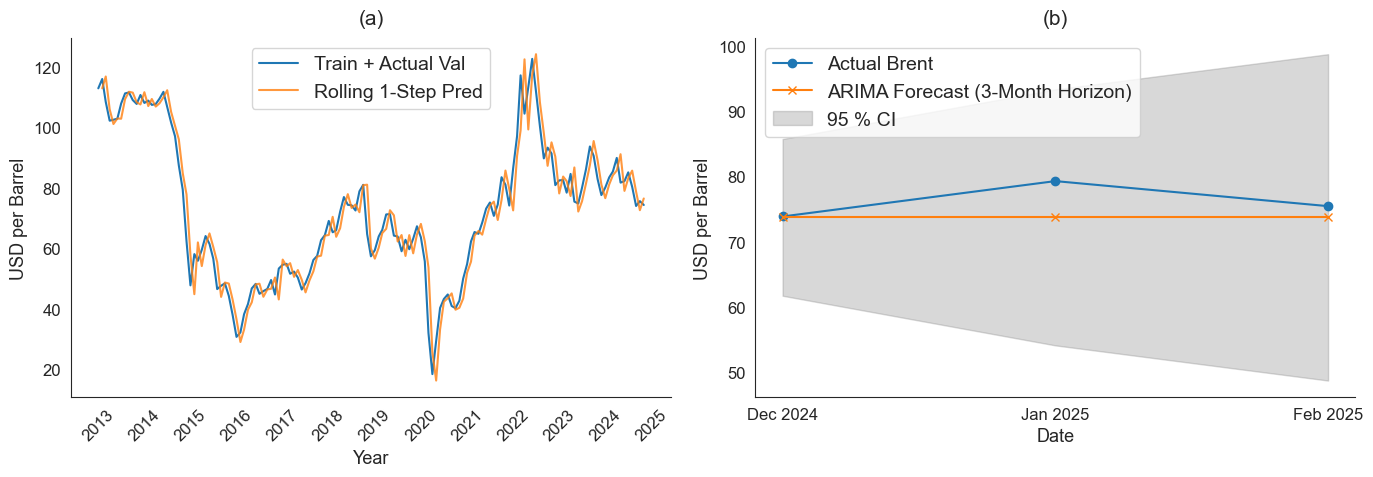

In [3]:
# =============================================================================
#  UNIVARIATE ARIMA FOR BRENT
#  ---------------------------------------------------------------------------
#  * Grid‑search (p,d,q) over the ranges below using statsmodels ARIMA.
#  * Best order = lowest AIC; tie‑break by BIC.
#  * Trains on train+validation (chronological) and forecasts the final
#    TEST_SIZE months.
#  * Reports MAE, RMSE, MAPE
#  * Plots: in‑sample rolling fit and 3‑month out‑of‑sample forecast.
#  * Useful:
#      statsmodels ARIMA   https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html
# =============================================================================

# ----------------------------------------------------------------------------
# USER INPUTS
# ----------------------------------------------------------------------------

ARIMA_P_MAX = 5   # maximum AR lag; higher = longer memory, slower fit, more risk of over-fit
ARIMA_D_SET = [0, 1]  # differencing orders to test; 0 = level series, 1 = first difference
ARIMA_Q_MAX = 5   # maximum MA lag; higher = longer shock memory, slower fit
TEST_SIZE   = 3   # months held out for the final test; higher = harder task, less training data
SEED        = 42  # random seed for reproducible model initialisation

# ----------------------------------------------------------------------------

# ----------------------------------------------------------------------------
# 0. Pull Brent series, ensure DatetimeIndex
# ----------------------------------------------------------------------------

brent_ts = df_all["Brent"].copy()
if isinstance(brent_ts.index, pd.PeriodIndex):
    brent_ts.index = brent_ts.index.to_timestamp()   # Period to Timestamp
else:
    brent_ts.index = pd.to_datetime(brent_ts.index)  # fallback

# ----------------------------------------------------------------------------
# 1. Chronological split
# ----------------------------------------------------------------------------

train_end = len(brent_ts) - TEST_SIZE
train_val = brent_ts.iloc[:train_end]       # train + validation
test_set  = brent_ts.iloc[train_end:]       # final TEST_SIZE months

# ----------------------------------------------------------------------------
# 2. Grid‑search best (p,d,q)
# ----------------------------------------------------------------------------

best_order, best_aic, best_bic = None, np.inf, np.inf

for d in ARIMA_D_SET:
    for p in range(ARIMA_P_MAX + 1):
        for q in range(ARIMA_Q_MAX + 1):
            if (p, d, q) == (0, 0, 0):
                continue                    # skip white‑noise model
            try:
                model = sm.tsa.ARIMA(train_val, order=(p, d, q)).fit()
                aic, bic = model.aic, model.bic
                if (aic < best_aic) or (aic == best_aic and bic < best_bic):
                    best_order, best_aic, best_bic = (p, d, q), aic, bic
            except Exception:
                # some orders fail to converge; safely skip
                continue

print(f"Best (p,d,q) by AIC/BIC: {best_order} | AIC={best_aic:.2f}, BIC={best_bic:.2f}")

# ----------------------------------------------------------------------------
# 3. Fit final model on train+val
# ----------------------------------------------------------------------------

final_model = sm.tsa.ARIMA(train_val, order=best_order).fit()
print(final_model.summary())                # optional full table

# ----------------------------------------------------------------------------
# 4. Rolling one‑step residuals
# ----------------------------------------------------------------------------

rolling_pred = final_model.get_prediction(start=1, end=len(train_val)-1).predicted_mean
rolling_mae  = mean_absolute_error(train_val.iloc[1:], rolling_pred)
print(f"Rolling one‑step MAE on train+val: {rolling_mae:.2f} USD/bbl")

# ----------------------------------------------------------------------------
# 5. Forecast TEST_SIZE months
# ----------------------------------------------------------------------------

forecast_res  = final_model.get_forecast(steps=TEST_SIZE)
forecast_mean = forecast_res.predicted_mean
forecast_ci   = forecast_res.conf_int(alpha=0.05)

test_mae  = mean_absolute_error(test_set, forecast_mean)
rmse      = np.sqrt(mean_squared_error(test_set, forecast_mean))
mape      = np.mean(np.abs((test_set - forecast_mean) / test_set)) * 100

print(f"\n[TEST] ARIMA MAE : {test_mae:.2f} USD/bbl")
print(f"       RMSE      : {rmse:.2f} USD/bbl")
print(f"       MAPE      : {mape:.2f} %")

# ----------------------------------------------------------------------------
# 5b.  Diagnostic
# ----------------------------------------------------------------------------

persistence_pred = np.repeat(train_val.iloc[-1], TEST_SIZE)
baseline_mae     = mean_absolute_error(test_set, persistence_pred)

if test_mae <= baseline_mae:
    print("→ ARIMA beats persistence on *test* ✅")
else:
    print("→ ARIMA fails on unseen data ❌")

#-----------------------------------------------------------------------------
# 6. Plots
#-----------------------------------------------------------------------------

# Style
mpl.rcParams.update({
    "font.family":  "serif",
    "font.serif":   ["Times New Roman"],
    "font.size":    14,
    "figure.facecolor":  "white",
    "axes.facecolor":    "white",
    "savefig.facecolor": "white",
})
sns.set_style("white")

# Build 1 by 2 figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Panel (a): rolling in sample one-step forecasts
ax1.plot(train_val.index, train_val, label="Train + Actual Val", linewidth=1.5)
ax1.plot(rolling_pred.index, rolling_pred,
         color="tab:orange", alpha=0.8, label="Rolling 1-Step Pred",
         linewidth=1.5)

ax1.set_title("(a)", pad=10, fontsize=15)
ax1.set_xlabel("Year", fontsize=13)
ax1.set_ylabel("USD per Barrel", fontsize=13)
ax1.legend()

# Year only ticks
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax1.tick_params(axis="x", labelrotation=45, labelsize=12)
ax1.tick_params(axis="y", labelsize=12)
sns.despine(ax=ax1)

# Panel (b): 3-month out of sample forecast
ax2.plot(test_set.index, test_set, marker="o", label="Actual Brent",
         linewidth=1.5)
ax2.plot(test_set.index, forecast_mean, marker="x", label=f"ARIMA Forecast ({TEST_SIZE}-Month Horizon)",
         linewidth=1.5)
ax2.fill_between(test_set.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1],
                 color="gray", alpha=0.3, label="95 % CI")

ax2.set_title("(b)", pad=10, fontsize=15)
ax2.set_xlabel("Date", fontsize=13)
ax2.set_ylabel("USD per Barrel", fontsize=13)
ax2.legend()

# Month+Year ticks (adjust interval if needed)
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
ax2.tick_params(axis="x", labelrotation=0, labelsize=12)
ax2.tick_params(axis="y", labelsize=12)
sns.despine(ax=ax2)

plt.tight_layout()

# Save
out_path = os.path.join(os.path.expanduser("~"), "Desktop", "arima_plots.png")
plt.savefig(out_path, dpi=300)
print(f"Saved to {out_path}")

plt.show()

In [4]:
# -------------------------------------------------
# Save 1-step forecast
# -------------------------------------------------

# Align actual Brent with rolling_pred index
actual_arima = train_val.iloc[1:].loc[rolling_pred.index]

# If the index is a PeriodIndex convert to timestamps, otherwise leave as is
date_col = (rolling_pred.index.to_timestamp()
            if isinstance(rolling_pred.index, pd.PeriodIndex)
            else rolling_pred.index)

df_arima_out = pd.DataFrame({
    "Date": date_col,
    "Actual_Brent": actual_arima.values,
    "ARIMA_1Step_Forecast": rolling_pred.values,
})

# Save
arima_path = Path.home() / "Desktop" / "arima_1step_forecast_vs_actual.xlsx"
df_arima_out.to_excel(arima_path, index=False)
print(f"Excel file saved to: {arima_path}")

Excel file saved to: C:\Users\manue\Desktop\arima_1step_forecast_vs_actual.xlsx


Dropped the first 1 residual(s); 142 remain.
Ljung–Box p-values after start-up removal:
  lag 12: 0.813
  lag 24: 0.475
Residual diagnostics saved to: C:\Users\manue\Desktop\arima_residual_diagnostics.png


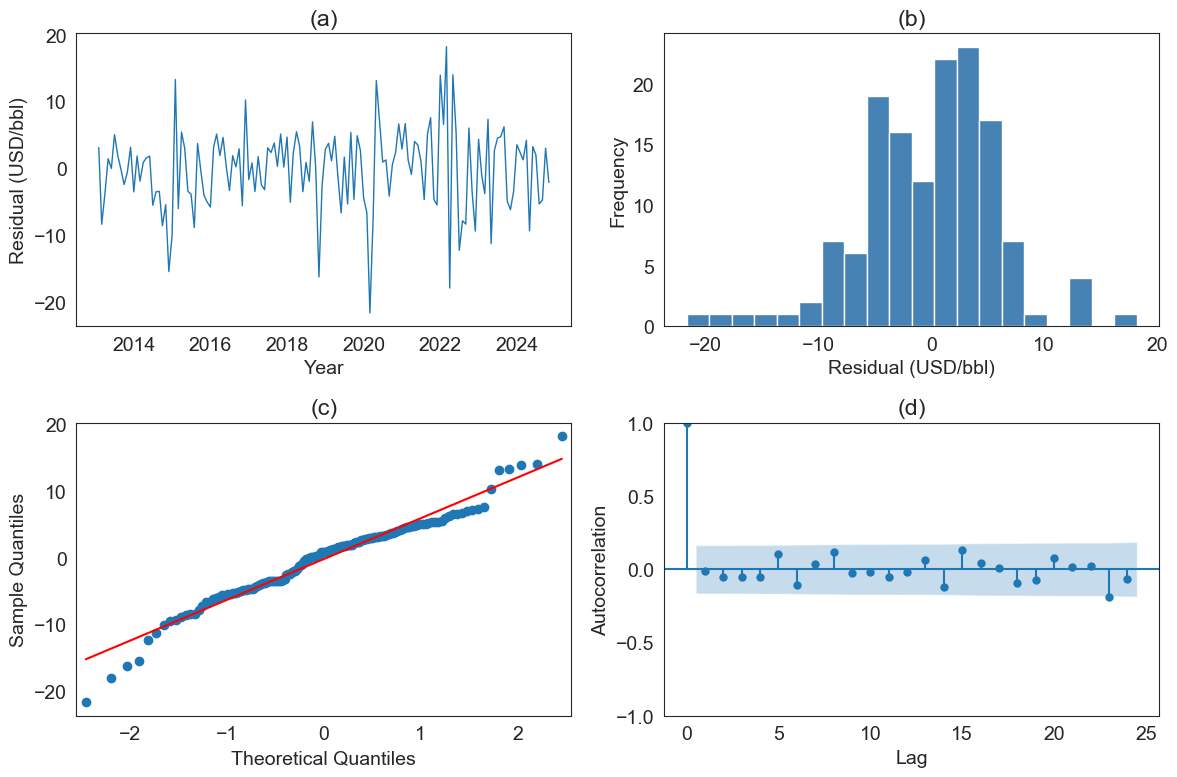

In [5]:
# -------------------------------------------------
# ARIMA RESIDUAL DIAGNOSTICS
# -------------------------------------------------
# Creates a 2 by 2 panel:
# (a) Residuals (b) Histogram (c) Normal Q-Q (d) ACF (24 lags)

# Style
mpl.rcParams.update({
    "font.family":  "serif",
    "font.serif":   ["Times New Roman"],
    "font.size":    14,
    "figure.facecolor": "white",
    "axes.facecolor":   "white",
    "savefig.facecolor": "white",
})
sns.set_style("white")

# Residuals and cut-off
resid_full = final_model.resid
p, d, q    = best_order
k_cut      = max(p, q)            # drop 1 if p or q > 0
resid      = resid_full.iloc[k_cut:]

print(f"Dropped the first {k_cut} residual(s); {len(resid)} remain.")

# Ljung–Box p-values
lb = sm.stats.acorr_ljungbox(resid, lags=[12, 24], return_df=True)["lb_pvalue"]
print("Ljung–Box p-values after start-up removal:")
print(f"  lag 12: {lb.iloc[0]:.3f}")
print(f"  lag 24: {lb.iloc[1]:.3f}")

# Plot
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.subplots_adjust(hspace=0.35, wspace=0.25)

# (a) Residuals vs Time
axes[0, 0].plot(resid.index, resid, lw=1)
axes[0, 0].set_title("(a)")
axes[0, 0].set_xlabel("Year")
axes[0, 0].set_ylabel("Residual (USD/bbl)")

# (b) Histogram
axes[0, 1].hist(resid, bins=20, color="steelblue", edgecolor="white")
axes[0, 1].set_title("(b)")
axes[0, 1].set_xlabel("Residual (USD/bbl)")
axes[0, 1].set_ylabel("Frequency")

# (c) Normal Q-Q
qqplot(resid, line="s", ax=axes[1, 0])
axes[1, 0].set_title("(c)")
axes[1, 0].set_xlabel("Theoretical Quantiles")
axes[1, 0].set_ylabel("Sample Quantiles")

# (d) ACF
plot_acf(resid, lags=24, ax=axes[1, 1])
axes[1, 1].set_title("(d)")
axes[1, 1].set_xlabel("Lag")
axes[1, 1].set_ylabel("Autocorrelation")

plt.tight_layout()

# Save
out_path = Path.home() / "Desktop" / "arima_residual_diagnostics.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight")
print(f"Residual diagnostics saved to: {out_path}")
plt.show()

Figure saved to: C:\Users\manue\Desktop\arima_trainval_vs_rolling.png


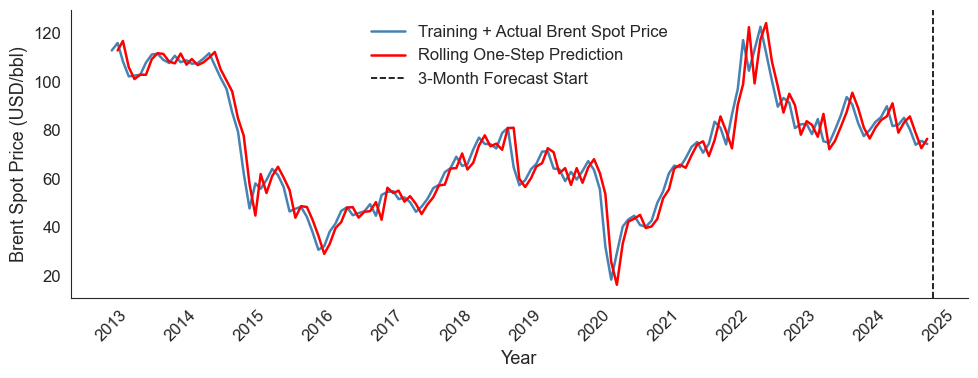

In [6]:
# -------------------------------------------------
# Plot Training + Actual Brent Spot Price  vs.  Rolling One-Step Prediction
# -------------------------------------------------

# Style
mpl.rcParams.update({
    "font.family":  "serif",
    "font.serif":   ["Times New Roman"],
    "font.size":    14,
    "figure.facecolor":  "white",
    "axes.facecolor":    "white",
    "savefig.facecolor": "white",
})
sns.set_style("white")

# Plot
fig, ax = plt.subplots(figsize=(10, 4))

# Actual training + val series
ax.plot(
    train_val.index,
    train_val,
    color="steelblue",
    linewidth=1.8,
    label="Training + Actual Brent Spot Price"
)

# Rolling 1-step predictions
ax.plot(
    rolling_pred.index,
    rolling_pred,
    color="red",
    linewidth=1.8,
    label="Rolling One-Step Prediction"
)

# Vertical marker for start of 3-month forecast horizon
forecast_start = test_set.index[0]                           # first test date
ax.axvline(
    forecast_start,
    color="black",
    linestyle="--",
    linewidth=1.2,
    label="3-Month Forecast Start"
)

# Axes
ax.set_xlabel("Year", fontsize=13)
ax.set_ylabel("Brent Spot Price (USD/bbl)", fontsize=13)

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.tick_params(axis="x", rotation=45, labelsize=12)
ax.tick_params(axis="y", labelsize=12)

ax.legend(frameon=False, fontsize=12)
sns.despine(ax=ax)
plt.tight_layout()

# Save
out_png = Path.home() / "Desktop" / "arima_trainval_vs_rolling.png"
fig.savefig(out_png, dpi=300, bbox_inches="tight")
print(f"Figure saved to: {out_png}")
plt.show()

In [7]:
# -------------------------------------------------
# EXPORT ACTUAL vs ARIMA FORECAST  ➜  EXCEL
# -------------------------------------------------

# Path
excel_path = r"C:\Users\manue\Desktop\arima_forecast_vs_actual.xlsx"

df_out = (
    pd.DataFrame({
        "Date": (
            test_set.index.to_timestamp()
            if isinstance(test_set.index, pd.PeriodIndex)
            else test_set.index
        ),
        "Actual_Brent": test_set.values,
        f"ARIMA_Forecast_{TEST_SIZE}m": forecast_mean.values,
    })
    .set_index("Date")
)

# Write to Excel
df_out.to_excel(excel_path, engine="openpyxl")
print(f"Excel file saved to {excel_path}")

Excel file saved to C:\Users\manue\Desktop\arima_forecast_vs_actual.xlsx


In [8]:
# -------------------------------------------------
# Export Train + Actual Val  &  Rolling 1-Step Pred  to  Excel
# -------------------------------------------------

# Concatenate on the shared DateTime index
df_export = pd.concat(
    [
        train_val.rename("Actual_TrainVal"),
        rolling_pred.rename("Rolling_1Step_Pred"),
    ],
    axis=1,
)

# Write to Excel (index labelled "Date")
excel_path = Path.home() / "Desktop" / "arima_trainval_vs_rolling.xlsx"
df_export.to_excel(excel_path, engine="openpyxl", index_label="Date")

print(f"Excel file saved to: {excel_path}")

Excel file saved to: C:\Users\manue\Desktop\arima_trainval_vs_rolling.xlsx
